In [57]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import confusion_matrix
from loss import ZINB, NB
from keras import backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from tensorflow.keras import regularizers


In [58]:
expr = pd.read_csv('five_tissue_annotate_color.txt', sep='\t')

In [60]:
X = expr.values[:,1:(expr.shape[1]-1)].astype(np.float64)
cell_ontology_class = expr.values[:,expr.shape[1]-1]
X = np.log(X + 1) 
#epsilon=np.random.rand(X.shape[0],X.shape[1])*(10**-8)
#X = X + epsilon
expr['Cluster'] = expr['tissue'].apply(lambda x:0 if x=='Heart' else 1 if x=='Bladder' else 2 if x=='Brain_Myeloid' else 3 if x=='Brain_Non-Myeloid' else 4)
Y = expr.values[:,expr.shape[1]-1]

In [61]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [47]:
y_train.shape

(3363,)

In [7]:
x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)
X = x_train


Constructing Autoencoder Model ...

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3363 samples, validate on 841 samples
Epoch 1/100
3363/3363 [==============================] - 35s 10ms/step - loss: 0.4154 - val_loss: 0.3219
Epoch 2/100
3363/3363 [==============================] - 56s 17ms/step - loss: 0.3002 - val_loss: 0.3056
Epoch 3/100
3363/3363 [==============================] - 49s 15ms/step - loss: 0.2902 - val_loss: 0.2995
Epoch 4/100
3363/3363 [==============================] - 36s 11ms/step - loss: 0.2868 - val_loss: 0.2995
Epoch 5/100
3363/3363 [==============================] - 34s 10ms/step - loss: 0.2860 - val_loss: 0.2985
Epoch 6/100
3363/3363 [==============================] - 34s 10ms/step - loss: 0.2842 - val_loss: 0.2989
Epoch 7/100
3363/3363 [==============================] - 34s 10ms/step - loss: 0.2844 - val_loss: 0.2970
Ep

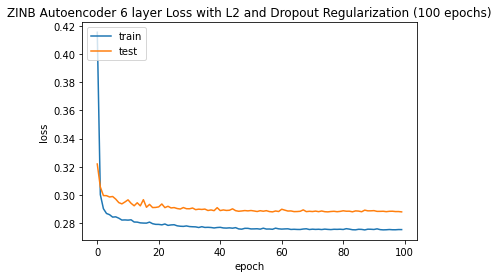

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 3363 samples in 0.017s...
[t-SNE] Computed neighbors for 3363 samples in 0.565s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3363
[t-SNE] Computed conditional probabilities for sample 2000 / 3363
[t-SNE] Computed conditional probabilities for sample 3000 / 3363
[t-SNE] Computed conditional probabilities for sample 3363 / 3363
[t-SNE] Mean sigma: 2.621295
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.921753
[t-SNE] KL divergence after 1000 iterations: 0.444299


Text(0.5, 1.0, 'tsne on ZINB Autoencoder 6 layer with L2 and Dropout Regularization (100 epochs)')

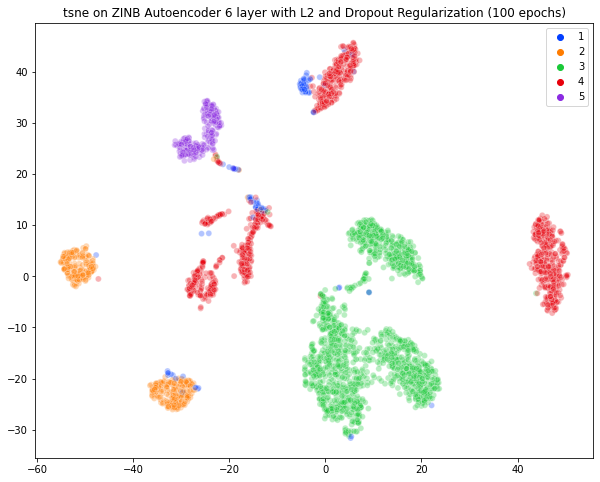

In [8]:
# DEFINE HYPERPARAMETERS
learning_rate   = 0.0001
training_epochs = 100
mini_batch_size = 100           # mini_batch_size = X.shape[0]-1
display_step    = 10             # how often to display loss and accuracy
num_hidden_1    = 30*32             # 1st hidden layer num features
num_hidden_2    = 30*8             # 2nd hidden layer num features
num_bottleneck  = 30              # bottleneck num features
num_input       = X.shape[1]     # scRANAseq data input (number of genes)
dropout_prob    = 0.2
l2_parameter    = 1e-4

initializer = tf.compat.v1.initializers.glorot_normal(seed=None)
bias_initializer = tf.keras.initializers.Zeros()

MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

# CONSTRUCT AUTOENCODER MODEL
print("\n" + "Constructing Autoencoder Model ..." + "\n")

# Zero-inflated negative binomial (ZINB) model is for modeling count variables with excessive zeros and it is usually for overdispersed count outcome variables.
def zinb_model(x, mean, inverse_dispersion, logit, eps=1e-8): 
                                      
    expr_non_zero = - tf.nn.softplus(- logit) \
                    + tf.log(inverse_dispersion + eps) * inverse_dispersion \
                    - tf.log(inverse_dispersion + mean + eps) * inverse_dispersion \
                    - x * tf.log(inverse_dispersion + mean + eps) \
                    + x * tf.log(mean + eps) \
                    - tf.lgamma(x + 1) \
                    + tf.lgamma(x + inverse_dispersion) \
                    - tf.lgamma(inverse_dispersion) \
                    - logit 

    expr_zero = - tf.nn.softplus( - logit) \
                + tf.nn.softplus(- logit + tf.log(inverse_dispersion + eps) * inverse_dispersion \
                                 - tf.log(inverse_dispersion + mean + eps) * inverse_dispersion) 
    
    template = tf.cast(tf.less(x, eps), tf.float32)
    expr =  tf.multiply(template, expr_zero) + tf.multiply(1 - template, expr_non_zero)
    return tf.reduce_sum(expr, axis=-1)

def model_and_loss():
    input_layer = Input(shape=(num_input,))
    layer_1 = Dense(num_hidden_1,activation='relu',kernel_initializer=initializer, bias_initializer= bias_initializer)(input_layer)
    layer_2 = Dense(num_hidden_2,activation='relu',kernel_initializer=initializer, bias_initializer= bias_initializer)(layer_1)
    bottleneck = Dense(num_bottleneck, kernel_initializer=initializer, bias_initializer= bias_initializer)(layer_2)
    layer__2 = Dense(num_hidden_2, activation='relu',kernel_initializer=initializer, bias_initializer= bias_initializer)(bottleneck)
    layer__1 = Dense(num_hidden_1, activation='relu',kernel_initializer=initializer, bias_initializer= bias_initializer)(layer__2)
    #output = Dense(num_input)(layer__1)
    pi = Dense(num_input)(layer__1)
    mean = Dense(num_input, activation=MeanAct)(layer__1)
    disp = Dense(num_input, activation=DispAct)(layer__1)
    
    zinb = ZINB(pi, theta=disp)
    
    ae_model = Model(input_layer, outputs=mean)
    encoder_model = Model(input_layer, outputs=bottleneck)

    return ae_model, zinb, encoder_model
    #return ae_model


def model_1_and_loss():
    input_layer = Input(shape=(num_input,))
    layer_1 = Dense(num_hidden_1,activation='relu',kernel_initializer=initializer, bias_initializer= bias_initializer, kernel_regularizer=regularizers.l2(l2_parameter))(input_layer)
    layer_1 = Dropout(rate=dropout_prob)(layer_1)
    bottleneck = Dense(num_bottleneck,  activation='relu', kernel_initializer=initializer, bias_initializer= bias_initializer)(layer_1)
    layer__1 = Dense(num_hidden_1, activation='relu',kernel_initializer=initializer, bias_initializer= bias_initializer, kernel_regularizer=regularizers.l2(l2_parameter))(bottleneck)
    layer__1 = Dropout(rate=dropout_prob)(layer__1)
    #output = Dense(num_input)(layer__1)
    pi = Dense(num_input, kernel_initializer=initializer, activation='sigmoid')(layer__1)
    mean = Dense(num_input, kernel_initializer=initializer, activation=MeanAct)(layer__1)
    disp = Dense(num_input, kernel_initializer=initializer, activation=DispAct)(layer__1)
    
    zinb = ZINB(pi, theta=disp)
    #zinb_loss = zinb_model(input_layer, mean, disp, pi)
    
    ae_model = Model(input_layer, outputs=mean)
    encoder_model = Model(input_layer, outputs=bottleneck)

    return ae_model, zinb, encoder_model

def mse_loss(y_true, y_pred):
    cost = tf.pow(y_true - y_pred, 2)
    return cost

autoencoder, zinb, encoder = model_1_and_loss()
#autoencoder = model_and_loss()
#cost = tf.pow(y_true - y_pred, 2)

autoencoder.compile(optimizer='adam', loss=zinb.loss)
history = autoencoder.fit(x_train, x_train, 
                epochs=training_epochs,
                batch_size=mini_batch_size,
                shuffle=True,
                validation_data=(x_test,x_test))


#Plot the loss function
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("ZINB Autoencoder 6 layer Loss with L2 and Dropout Regularization (" + str(training_epochs) + " epochs)")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Plot the TSNE for the training and see how the tissues cluster
y_pred=encoder.predict(x_train)
model_tsne_auto = TSNE(learning_rate = 100, n_components = 2, random_state = 123,
                       perplexity = 90, n_iter = 1000, verbose = 1)
tsne_auto = model_tsne_auto.fit_transform(y_pred)

expr_auto={}
expr_auto['tissue'] = y_train
expr_auto['tsne_1'] = tsne_auto[:,0]
expr_auto['tsne_2'] = tsne_auto[:,1]
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="tissue",
    palette=sns.color_palette("bright", 5),
    data=expr_auto,
    legend="full",
    alpha=0.3
)
ax = plt.gca()
ax.set_title("tsne on ZINB Autoencoder 6 layer with L2 and Dropout Regularization (" + str(training_epochs) + " epochs)")

In [62]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# convert integers to dummy variables (i.e. one hot encoded)
cluster = np_utils.to_categorical(y_train)
 
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=30, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, y_pred, cluster, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 98.45% (0.42%)


In [73]:
# convert integers to dummy variables (i.e. one hot encoded)
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

cluster = np_utils.to_categorical(y_train)
 
# define baseline model
# create model
model = Sequential()
model.add(Dense(8, input_dim=30, activation='relu'))
model.add(Dense(5, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit([y_pred], batch_size=5, y=to_categorical(y_train), verbose=1,validation_split=0.2, 
          shuffle=True, epochs=100)

Train on 2690 samples, validate on 673 samples
Epoch 1/100
2690/2690 [==============================] - 1s 533us/step - loss: 1.4097 - accuracy: 0.7097 - val_loss: 0.2389 - val_accuracy: 0.9376
Epoch 2/100
2690/2690 [==============================] - 1s 311us/step - loss: 0.1860 - accuracy: 0.9502 - val_loss: 0.1501 - val_accuracy: 0.9569
Epoch 3/100
2690/2690 [==============================] - 1s 316us/step - loss: 0.1367 - accuracy: 0.9546 - val_loss: 0.1267 - val_accuracy: 0.9569
Epoch 4/100
2690/2690 [==============================] - 1s 345us/step - loss: 0.1183 - accuracy: 0.9565 - val_loss: 0.1145 - val_accuracy: 0.9614
Epoch 5/100
2690/2690 [==============================] - 1s 318us/step - loss: 0.1060 - accuracy: 0.9602 - val_loss: 0.1018 - val_accuracy: 0.9658
Epoch 6/100
2690/2690 [==============================] - 1s 341us/step - loss: 0.0961 - accuracy: 0.9647 - val_loss: 0.1000 - val_accuracy: 0.9688
Epoch 7/100
2690/2690 [==============================] - 1s 325us/step 

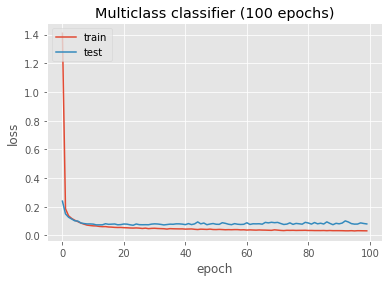

<Figure size 432x288 with 0 Axes>

In [76]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Multiclass classifier (" + str(training_epochs) + " epochs)")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('multiclass.png')

In [ ]:
# Will be used in later triplet loss development 
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist-neg_dist+alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    ### END CODE HERE ###
    
    return loss